<img src="http://hilpisch.com/tpq_logo.png" width="36%" align="right" style="vertical-align: top;">

# Dow Jones DNA NLP Case Study

_Based on news articles related to Elon Musk, Twitter & Tesla._

**Basic Techniques and Algorithms**

Dr Yves J Hilpisch

The Python Quants GmbH

## The Imports

In [1]:
import os
import sys
sys.path.append('../../modules')
import warnings; warnings.simplefilter('ignore')

In [2]:
import nltk
import pprint
import collections
import pandas as pd
from pylab import plt
import nlp_functions as nlp
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from gensim.summarization import keywords
from gensim.summarization.summarizer import summarize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# to be executed once
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

## Raw Data

In [4]:
project = 'musk_100'

In [5]:
abs_path = os.path.abspath('../../')

In [6]:
data_path = os.path.join(abs_path, 'data_musk')

In [7]:
snapshot_path = os.path.join(data_path, 'snapshot')

In [8]:
fn = os.path.join(snapshot_path, 'snapshot_{}.h5'.format(project))

In [9]:
raw = pd.read_hdf(fn, 'data')

## Data Selection

In [10]:
sel = raw[raw['company_codes_about'].apply(
            lambda s: s.find('teslmi') != -1)]  

In [11]:
titles = sel['title']  

In [12]:
dates = sel['publication_date'].values.tolist()  

In [13]:
dates = [pd.Timestamp(date * 1000000) for date in dates]  

In [14]:
data = sel['body'].values.tolist()  

## Basic Text Analytics

In [15]:
tokens = nltk.word_tokenize(' '.join(data))  

In [16]:
text = nltk.Text(tokens)  

In [17]:
text.count('Tesla')

526

In [18]:
text.count('SEC')

96

In [19]:
text.similar('Musk')

he tesla it the investors that his funding million him banks years
they in stock there this because comment sec


In [20]:
text.collocations()  

Mr. Musk; Elon Musk; Wall Street; New York; Saudi Arabia; Exchange
Commission; per cent; stock price; social media; people familiar; per
share; short sellers; funding secured; last week; Tesla private; chief
executive; considering taking; board members; Dow Jones; sovereign
wealth


In [21]:
text.concordance('tweet', width=70, lines=7)

Displaying 7 of 100 matches:
ed , '' Musk wrote in an Oct. 4 tweet . `` What they do should be ill
Investors panicked that Musk 's tweet would sink the settlement , and
funding `` secured , '' and one tweet elaborated that the deal was so
ly investigating Musk 's Aug. 7 tweet and skepticism surrounding the 
llowing Musk 's Tuesday morning tweet that he had confirmed funding f
at $ 420 a share . Prior to the tweet , shares closed Monday at $ 341
 on Tesla 's upside . `` If the tweet was false , the liability could


In [22]:
text.concordance('SEC', width=70, lines=7)

Displaying 7 of 96 matches:
eted it . Musk , Tesla , and the SEC were in court on Thursday seekin
inst Tesla shorts and teased the SEC . `` The Shortseller Enrichment 
 are for mischievous longs . The SEC showed its willingness to go aft
2 press release he condemned the SEC case . `` The action is an effor
will be proven to be so . '' The SEC will have done Tesla shareholder
ion and profitability . With the SEC reportedly investigating Musk 's
ive a wayward tweet , a possible SEC investigation and the consequenc


In [23]:
text.concordance('settlement', width=70, lines=7)

Displaying 7 of 15 matches:
ursday seeking approval for a settlement in which he and his company a
mplements another part of the settlement . Under a board committee of 
 . Days after agreeing to the settlement , Musk launched his crusade a
 Musk 's tweet would sink the settlement , and the next day , Tesla st
areholders a favor if Musk 's settlement gets him back to business . H
e one . Musk entered into the settlement with SEC involving such a hef
, 2018 Under the terms of the settlement between Musk , Tesla and the 


## Similarity

In [24]:
vec = nlp.TfidfVectorizer(stop_words='english')

In [25]:
mat = vec.fit_transform(data)

In [26]:
(mat * mat.T).A.round(2)  #  <1>

array([[1.  , 0.08, 0.07, ..., 0.04, 0.17, 0.12],
       [0.08, 1.  , 0.04, ..., 0.03, 0.04, 0.04],
       [0.07, 0.04, 1.  , ..., 0.03, 0.12, 0.04],
       ...,
       [0.04, 0.03, 0.03, ..., 1.  , 0.04, 0.02],
       [0.17, 0.04, 0.12, ..., 0.04, 1.  , 0.05],
       [0.12, 0.04, 0.04, ..., 0.02, 0.05, 1.  ]])

## Word Clouds

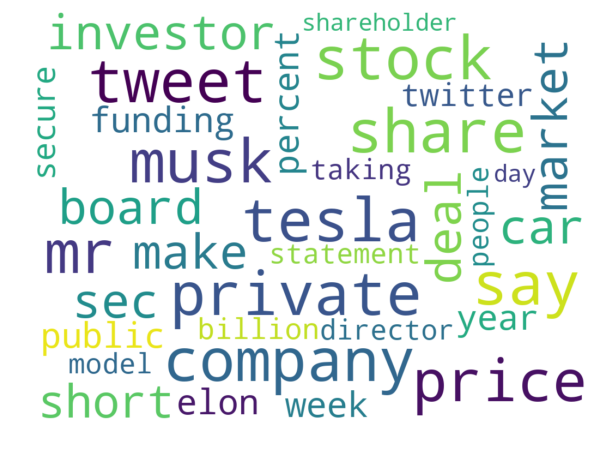

In [27]:
nlp.generate_word_cloud(''.join(data), 35,
                       name='wc_musk.png')

## Topic Modeling

### NMF Clustering

In [28]:
vec = nlp.TfidfVectorizer(stop_words='english')

In [29]:
mat = vec.fit_transform(data)

In [30]:
nmf = NMF(n_components=6)

In [31]:
nmf.fit(mat)  

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [32]:
nmf.components_.round(3)

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.035, 0.   , 0.008, ..., 0.004, 0.01 , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.002, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.002, 0.002, ..., 0.015, 0.   , 0.   ],
       [0.058, 0.003, 0.014, ..., 0.   , 0.   , 0.009]])

In [33]:
feature_names = vec.get_feature_names()

In [34]:
n_words = 6

In [35]:
for i, topic in enumerate(nmf.components_[:n_words]):
    print('TOPIC %d'% (i))
    print(60 * '=')
    print(', '.join([feature_names[i] for i in
                     topic.argsort()[:-n_words-1:-1]]) + '\n')  

TOPIC 0
musk, sec, price, tesla, complaint, tweets

TOPIC 1
mr, musk, said, tesla, year, weed

TOPIC 2
maker, shares, considering, aug, shareholders, private

TOPIC 3
buyout, history, tesla, mr, dramas, tuesday

TOPIC 4
board, musk, said, tesla, company, percent

TOPIC 5
stock, tesla, short, musk, sellers, earnings



## Summarization

In [36]:
for i, text in enumerate(data[:3]):
    print('\nTEXT {}\n'.format(i) + 50 * '=')
    kws = keywords(text, words=8, split=False,
                   lemmatize=True, scores=True)
    pprint.pprint(kws)


TEXT 0
[('tesla', 0.402436471045576),
 ('musk', 0.34542986307002654),
 ('short', 0.23340039872834645),
 ('stocks', 0.22361056070219207),
 ('company', 0.17768994280728978),
 ('investor', 0.14823419104749117),
 ('public', 0.1474826235111266),
 ('share', 0.13050214444261343)]

TEXT 1
[('service', 0.4452852768639727),
 ('teslas', 0.3391990600243171),
 ('said', 0.2083737608800266),
 ('customer', 0.18150505810519965),
 ('bhaskar', 0.1497108552001281),
 ('problem', 0.13579973739299342),
 ('auto', 0.13563985089950711),
 ('times', 0.127779498428788)]

TEXT 2
[('musk', 0.25213864942730896),
 ('private', 0.2450358739288957),
 ('tesla', 0.24259913577379186),
 ('wealth', 0.20919697806593424),
 ('came', 0.20919697806593354),
 ('cash', 0.20919697806593232),
 ('twitter post', 0.18608879985202267)]


In [37]:
for i, text in enumerate(data[:3]):
    print('\nTEXT {}\n'.format(i) + 50 * '=')
    print(summarize(text, word_count=25))


TEXT 0
Investors panicked that Musk's tweet would sink the settlement, and the next day, Tesla stock fell $20, to $262.

TEXT 1
A Tesla service agent said he couldn't leave the car there because the facility was too busy.

TEXT 2
The talks would come as a blow to Tesla CEO Elon Musk who has said PIF could help him fund a $72 billion deal to take his electric car maker private.


## Sentiment Analysis

In [38]:
sid = SentimentIntensityAnalyzer()

In [39]:
scores = [sid.polarity_scores(text) for text in data]  

In [40]:
scores = pd.DataFrame(scores, index=dates)  

In [41]:
scores.head()

,compound,neg,neu,pos
2018-10-15 00:00:00,0.9646,0.081,0.809,0.110
2018-07-28 00:00:00,-0.9903,0.085,0.871,0.044
2018-08-20 00:00:00,0.5719,0.013,0.953,0.034
2018-08-26 23:30:00,0.9844,0.036,0.902,0.062
2018-08-27 19:20:39,0.9905,0.043,0.826,0.131


In [42]:
scores.sort_index(inplace=True)  

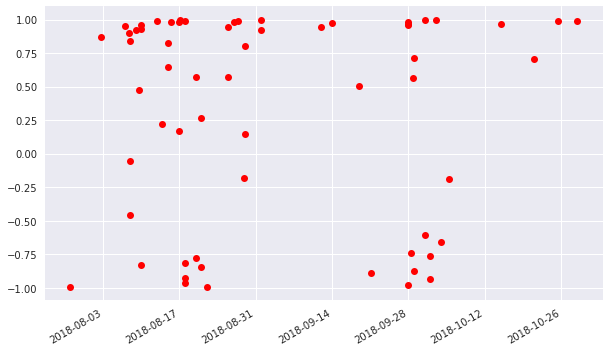

In [43]:
scores['compound'].plot(figsize=(10, 6), style='ro');

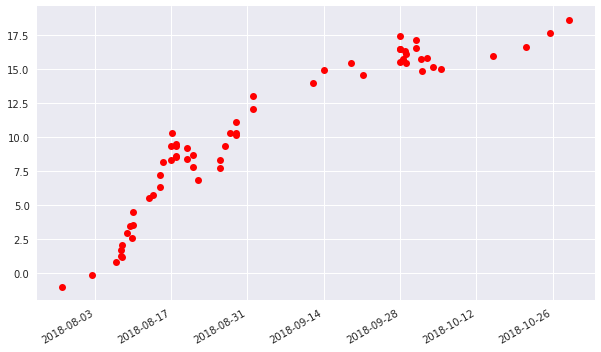

In [44]:
scores['compound'].cumsum().plot(figsize=(10, 6), style='ro');

In [45]:
tsla = pd.read_csv('../../data/eikon_eod_tsla_data.csv',
                   index_col=0, parse_dates=True)  

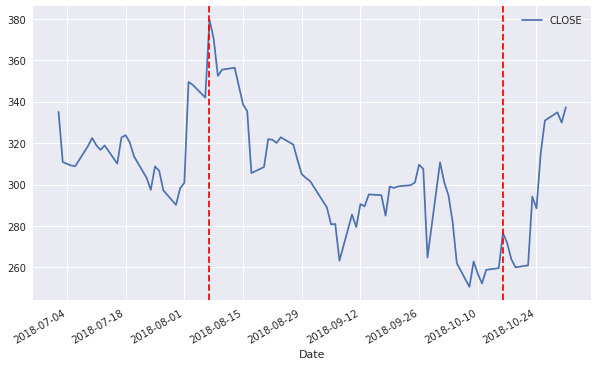

In [46]:
tsla.loc['2018-07-01':].plot(figsize=(10, 6))
plt.axvline(pd.Timestamp('2018-08-07'), c='r', ls='--')
plt.axvline(pd.Timestamp('2018-10-16'), c='r', ls='--')

In [47]:
start = scores.index[0]  
end = scores.index[-1]  
tsla_ = tsla.loc[start:end]

In [48]:
df = pd.DataFrame(tsla_).join(scores['compound'].cumsum(),
                              how='outer')   
df.columns = ['TSLA.O','CUM_SENTIMENT']  

In [49]:
df['TSLA.O'] = df['TSLA.O'].interpolate()  

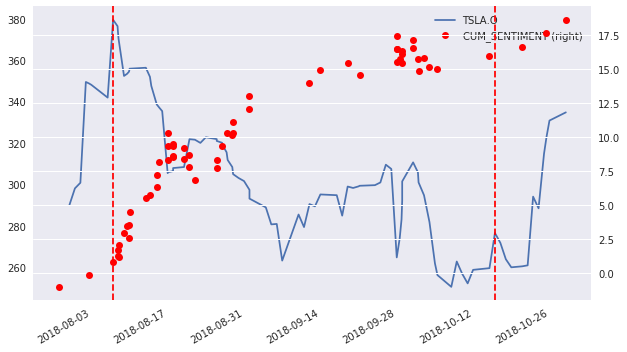

In [50]:
df.plot(secondary_y='CUM_SENTIMENT', style=['-', 'ro'], figsize=(10, 6))
plt.axvline(pd.Timestamp('2018-08-07'), c='r', ls='--')
plt.axvline(pd.Timestamp('2018-10-16'), c='r', ls='--')

<img src="http://hilpisch.com/tpq_logo.png" width="36%" align="right" style="vertical-align: top;">